**MSRF-Net: A Multi-Scale Residual Fusion
Network for Biomedical Image Segmentation**


MSRF-Net is able to exchange multi-scale features of varying
receptive fields using a Dual-Scale Dense Fusion (DSDF) block.

MSRF sub-network uses
multiple DSDF blocks in sequence to perform multi-scale fusion.
This allows the preservation of resolution, improved information
flow and propagation of both high- and low-level features to
obtain accurate segmentation maps.




---





*   DSDF block that comprises of residual dense connections and exchanging information across multiple scales.
*   Four datasets : Kvasir-SEG, CVC-ClinicDB,
2018 Data Science Bowl (DSB) Challenge, and ISIC
2018 Challenge


*   decoder layers with skip-connections from our sub-network and
a triple attention mechanism are used
*    gated shape stream for the shape prediction



---





**Testing**

For testing purposes, run these sections :


1.   Prequisites
2.   Helper functions
3.   Data Prepration
4.   Model
5.   Loss
6.   Load model
7.   visualization -> choose your desired image index to perform segmentation





---


Mahtab Sarlak

Vision course project (Under supervision of Dr. Ebrahimi moghadam)

Summer 2022



In [ ]:
from google.colab import drive
 #  http://194.225.24.96/moshavereh-dr-ebrahimi-moghadam
# Accessing My Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprequisites

In [ ]:
# pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install -U albumentations
import tensorflow as tf
import os
import numpy as np
import cv2
import json
from tqdm import tqdm
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from glob import glob
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image
from os import listdir
from os.path import isfile, join
import warnings
from keras import backend as K
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import sklearn
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.initializers import RandomNormal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    Crop,
    RandomRotate90,
)
import albumentations as A

# Helper functions

In [ ]:
def create_dir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def get_image(image_path, image_size_wight, image_size_height,gray=False):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    if gray==True:
        img = img.convert('L')
    img_center_crop = img
    img_resized = img_center_crop.resize((image_size_height, image_size_wight), Image.ANTIALIAS)
    edge = cv2.Canny(np.asarray(np.uint8(img_resized)),10,1000)
    
    flag = False
    img_array = np.asarray(img_resized).astype(np.float32)/255.0
    edge = np.asarray(edge).astype(np.float32)/255.0
    if gray==True:
        img_array=(img_array >=0.5).astype(int)
    img.close()
    return img_array,edge

# Data

## CVC

In [ ]:
! mkdir data
!unrar x "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/PNG.rar" "/content/drive/MyDrive/msvision/data/cvc/"
! mkdir data/cvc
! mkdir /content/data/cvc/masks
! mkdir /content/data/cvc/images
! mv /content/drive/MyDrive/msvision/data/cvc/Original/*.png /content/data/cvc/images
! mv /content/drive/MyDrive/msvision/data/cvc/Ground\ Truth/*.png /content/data/cvc/masks

mkdir: cannot create directory ‘data’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/PNG.rar

Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/1.png        0%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/10.png       0%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/100.png       0%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/101.png       0%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/102.png       0%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/103.png       1%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/104.png       1%  OK 
Extracting  /content/drive/MyDrive/msvision/data/cvc/Original/105.png       1%  OK 
Extracting  /content/drive/MyDrive/msvision/da

In [ ]:
# rm -r /content/data/cvc

Number of images for cvc

In [ ]:
! find /content/data/cvc/images -type f | wc -l

612


Number of masks for cvc

In [ ]:
! find /content/data/cvc/masks -type f | wc -l

612


## Kvasir

In [ ]:
! mkdir data
# ! wget -O https://datasets.simula.no/downloads/kvasir-seg.zip
# !unzip -d x "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/PNG.rar" "/content/drive/MyDrive/msvision/data/cvc/"
! mkdir data/kvasir
! mkdir /content/data/kvasir/masks
! mkdir /content/data/kvasir/images
! cp /content/drive/MyDrive/msvision/data/kvasir/Kvasir-SEG/images/*.jpg /content/data/kvasir/images
! cp /content/drive/MyDrive/msvision/data/kvasir/Kvasir-SEG/masks/*.jpg /content/data/kvasir/masks

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/kvasir’: File exists
mkdir: cannot create directory ‘/content/data/kvasir/masks’: File exists
mkdir: cannot create directory ‘/content/data/kvasir/images’: File exists


In [ ]:
! find /content/data/kvasir/images -type f | wc -l

1000


# Pre Processing

## Augmentation

In [ ]:
def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    crop_size = (192-32, 256-32)
    size = (512, 384)
    # size = (384, 288)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        x = cv2.resize(x, size)
        y = cv2.resize(y, size)
        # print(x.shape)
        # print(y.shape)

        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:

            ## Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            # ## Horizontal Flip
            # aug = A.HorizontalFlip(p=1)
            # augmented = aug(image=x, mask=y)
            # x2 = augmented['image']
            # y2 = augmented['mask']

           # ## Random Rotate 90 degree
            # aug = A.RandomRotate90(p=1)
            # augmented = aug(image=x, mask=y)
            # x3 = augmented['image']
            # y3 = augmented['mask']

  
            images = [
                x, x1
            ]
            masks  = [
                y,  y1
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)
            # print('inja', i.shape)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


### Visualisation

In [ ]:
aug_list = ["original",
            "Vertical Flip",
            "Horizontal Flip",
            ]

In [ ]:
def visualise_augmentation(path):

    img_path = glob(os.path.join(path, "image/*"))
    msk_path = glob(os.path.join(path, "mask/*"))

    img_path.sort()
    msk_path.sort()

    
    rows = 1
    columns = 2
    for i in range(0,len(aug_list)):
      fig = plt.figure(figsize=(8, 8))
      fig.add_subplot(rows, columns,  1)
      img = cv2.imread(img_path[i], cv2.IMREAD_COLOR)
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.title(aug_list[i])
 
      fig.add_subplot(rows, columns, 2)
      msk = cv2.imread(msk_path[i], cv2.IMREAD_COLOR)
      plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.title(aug_list[i])



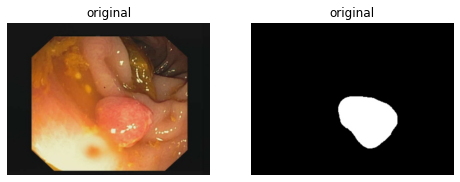

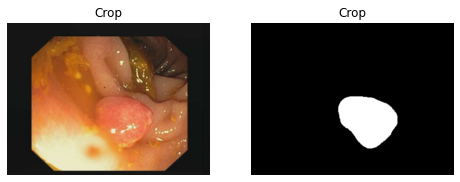

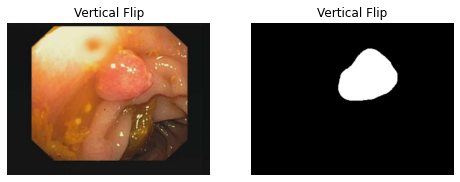

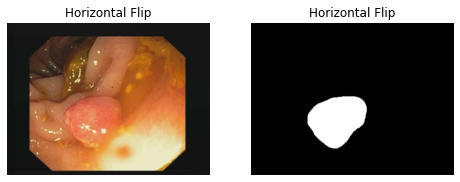

In [ ]:
visualise_augmentation("/content/drive/MyDrive/msvision/data/cvc/new_data/train/")

## Split

In [ ]:
def load_data(path, split=0.1):
    # Load all the data and then split them into train and valid dataset.
    img_path = glob(os.path.join(path, "images/*"))
    msk_path = glob(os.path.join(path, "masks/*"))

    img_path.sort()
    msk_path.sort()

    len_ids = len(img_path)
    train_size = int((80/100)*len_ids)
    valid_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for validation
    test_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for testing

    train_x, test_x = train_test_split(img_path, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(msk_path, test_size=test_size, random_state=42)

    train_x, valid_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def split_augment_data(path,path2):
    np.random.seed(42)
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path2, split=0.1)

    create_dir(path + "/new_data1/train/image/")
    create_dir(path + "/new_data1/train/mask/")
    create_dir(path + "/new_data1/valid/image/")
    create_dir(path + "/new_data1/valid/mask/")
    create_dir(path + "/new_data1/test/image/")
    create_dir(path + "/new_data1/test/mask/")

    augment_data(train_x, train_y, path + "/new_data1/train/", augment=False)
    augment_data(valid_x, valid_y, path + "/new_data1/valid/", augment=False)
    augment_data(test_x, test_y, path + "/new_data1/test/", augment=False)

## CVC

In [ ]:
split_augment_data("/content/drive/MyDrive/msvision/data/cvc","data/cvc")

100%|██████████| 61/61 [00:22<00:00,  2.66it/s]


In [ ]:
! find /content/drive/MyDrive/msvision/data/cvc/new_data/train -type f | wc -l

1960


## kvasir

In [ ]:
split_augment_data("/content/drive/MyDrive/msvision/data/kvasir","data/kvasir")

100%|██████████| 100/100 [00:02<00:00, 35.18it/s]


In [ ]:
! find /content/drive/MyDrive/msvision/data/kvasir/new_data1/train -type f | wc -l

1600


# Data prepration

In [ ]:
def prepare_train_data(train_path,valid_path,path):
    np.random.seed(42)
    tf.random.set_seed(42)
    create_dir(path + "/files")
    
    train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
    train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))
    train_x, train_y = shuffling(train_x, train_y)
    valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
    valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

    return train_x,train_y, valid_x, valid_y

def prepare_data(data, grey=False):
  X_tot = [get_image(sample_file, 256, 256, grey) for sample_file in data]
  x, edge = [] , []
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  return x, edge

In [ ]:
train_x,train_y, valid_x, valid_y = prepare_train_data("/content/drive/MyDrive/msvision/data/cvc/new_data/train/",
                                                       "/content/drive/MyDrive/msvision/data/cvc/new_data/valid/",
                                                       "/content/drive/MyDrive/msvision/data/cvc")

In [ ]:
x_train , x_train_edge = prepare_data(train_x)
x_valid , x_valid_edge = prepare_data(valid_x)
y_train , y_train_edge = prepare_data(train_y, True)
y_valid , y_valid_edge = prepare_data(valid_y,True)

In [ ]:
len(x_train)

980

# Model

**The DSDF Block**

It helps to exchange information between scales, preserve low-level features, and improves information flow while maintaining resolution.
![picture](https://drive.google.com/uc?export=view&id=1qALQT1SctYPyr82kx4UjHjRJ3Wg7UCBX)

In [ ]:
# DSDF Block
def RDDB(x,y,nf1=128,nf2=1212,gc=64,bias=True):
    x1 = Conv2D(filters=gc, kernel_size=3, strides=1,padding='same', use_bias=bias)(x)
    x1 = LeakyReLU(alpha=0.25)(x1)
    
    y1 = Conv2D(filters=gc, kernel_size=3, strides=1,padding='same', use_bias=bias)(y)
    y1 = LeakyReLU(alpha=0.25)(y)
    
    x1c = Conv2D(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(x)
    x1c = LeakyReLU(alpha=0.25)(x1c)
    y1t = Conv2DTranspose(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(y)
    y1t = LeakyReLU(alpha=0.25)(y1t)
    
    
    x2_input = concatenate([x,x1,y1t],axis=-1)
    x2 = Conv2D(filters= gc, kernel_size=3,strides=1, padding='same',use_bias=bias)(x2_input)
    x2 = LeakyReLU(alpha=0.25)(x2)
    
    y2_input = concatenate([y,y1,x1c],axis=-1)
    y2 = Conv2D(filters= gc, kernel_size=3,strides=1, padding='same',use_bias=bias)(y2_input)
    y2 = LeakyReLU(alpha=0.25)(y2)
    
    x2c = Conv2D(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(x1)
    x2c = LeakyReLU(alpha=0.25)(x2c)
    y2t = Conv2DTranspose(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(y1)
    y2t = LeakyReLU(alpha=0.25)(y2t)
    
    
    
    x3_input = concatenate([x,x1,x2,y2t] , axis=-1)
    x3 = Conv2D(filters= gc, kernel_size=3,strides=1, padding='same', use_bias=bias)(x3_input)
    x3 = LeakyReLU(alpha=0.25)(x3)
    
    y3_input = concatenate([y,y1,y2,x2c] , axis=-1)
    y3 = Conv2D(filters= gc, kernel_size=3,strides=1, padding='same', use_bias=bias)(y3_input)
    y3 = LeakyReLU(alpha=0.25)(y3)
    
    x3c = Conv2D(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(x3)
    x3c = LeakyReLU(alpha=0.25)(x3c)
    y3t = Conv2DTranspose(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(y3)
    y3t = LeakyReLU(alpha=0.25)(y3t)
    
    
        
    x4_input = concatenate([x,x1,x2,x3,y3t] , axis=-1)
    x4 = Conv2D(filters= gc, kernel_size=3,strides=1, padding='same', use_bias=bias)(x4_input)
    x4 = LeakyReLU(alpha=0.25)(x4)
    
    
    y4_input = concatenate([y,y1,y2,y3,x3c] , axis=-1)
    y4 = Conv2D(filters= gc, kernel_size=3,strides=1, padding='same', use_bias=bias)(y4_input)
    y4 = LeakyReLU(alpha=0.25)(y4)
    
    x4c = Conv2D(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(x4)
    x4c = LeakyReLU(alpha=0.25)(x4c)
    y4t = Conv2DTranspose(filters=gc, kernel_size=3, strides=2,padding='same', use_bias=bias)(y4)
    y4t = LeakyReLU(alpha=0.25)(y4t)
    
        
    x5_input = concatenate([x,x1,x2,x3,x4,y4t] , axis=-1)
    x5 = Conv2D(filters= nf1, kernel_size=3,strides=1, padding='same', use_bias=bias)(x5_input)
    x5 = LeakyReLU(alpha=0.25)(x5)
    
    y5_input = concatenate([y,y1,y2,y3,y4,x4c] , axis=-1)
    y5 = Conv2D(filters= nf2, kernel_size=3,strides=1, padding='same', use_bias=bias)(y5_input)
    y5 = LeakyReLU(alpha=0.25)(y5)
        
    x5 = Lambda(lambda x: x * 0.4)(x5)
    y5 = Lambda(lambda x: x * 0.4)(y5)
        
    return Add()([x5,x]),Add()([y5,y])

**Squeeze & excitation Block**

![picture](https://drive.google.com/uc?export=view&id=1zWv-5lzaxxS45NCPYa0D2qMVkLN-oADY)

In [ ]:
def se_block(in_block, ch, ratio=16):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    return Multiply()([in_block, x])

**Res Block**

![picture](https://drive.google.com/uc?export=view&id=1Besgs4Lel4RraGP8rp7kskqFobJn30LM)

In [ ]:
def resblock(x,ip_channels,op_channels,stride=(1,1)):
    residual = x
    out = Conv2D(op_channels,kernel_size=(3,3),strides=stride,padding='same')(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(op_channels,kernel_size=(3,3),strides=stride,padding='same')(x)
    out = BatchNormalization()(out)
    out = Add()([out,residual])
    out = Activation('relu')(out)
    return out

**Gated Conv**

![picture](https://drive.google.com/uc?export=view&id=123Y73tOjYU-Ti_0sLrJzkuNk_mDAlqeu)

In [ ]:
# Gated convolution
def gsc(input_features,gating_features,in_channels,out_channels,kernel_size=1,stride=1,dilation=1,groups=1):
    x = Concatenate()([input_features,gating_features])
    x = BatchNormalization()(x)
    x = Conv2D(in_channels+1, (1,1), strides =(1,1), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(1,kernel_size=(1,1),strides=1,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    return x

**The Attention part**

we use two attention mechanisms.
The first attention mechanism applies channel and spatial attention, whereas the second attention uses a gating mechanism


![picture](https://drive.google.com/uc?export=view&id=1ihXW3hx_EOm4lTbtKYg7ayYnSSZymo53)

**Attention block**

![picture](https://drive.google.com/uc?export=view&id=1lo2JPxD_R8PtxB726y_S2GYeb9EKOJSD)

In [ ]:
def Attention_B(X, G, k):
    FL = int(X.shape[-1])
    init = RandomNormal(stddev=0.02)
    theta = Conv2D(k,(2,2), strides = (2,2), padding='same')(X)
    Phi = Conv2D(k, (1,1), strides =(1,1), padding='same', use_bias=True)(G)
   
    ADD = Add()([theta, Phi])
    ADD = Activation('relu')(ADD)
    Psi = Conv2D(1,(1,1), strides = (1,1), padding="same",kernel_initializer=init)(ADD)
    Psi = Activation('sigmoid')(Psi)
    Up = Conv2DTranspose(1, (2,2), strides=(2, 2), padding='valid')(Psi)
    Final = Multiply()([X, Up])
    Final = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-5)(Final)
    print(Final.shape)
    return Final

**Up block**

![picture](https://drive.google.com/uc?export=view&id=12rDOIg5k7PMVeo0rTV8J_T-8_dpQWlp-)

In [ ]:
def Up3(input1,input2,kernel=(3,3),stride=(1,1), pad='same'):
    up = Conv2DTranspose(int(input1.shape[-1]),(1, 1), strides=(2, 2), padding='same')(input2)
    up = Concatenate()([up,input1])
    
    return up

**Spatial attention block**

![picture](https://drive.google.com/uc?export=view&id=1vzsNa8v_YeH5D0VPbPWOqa53cvJSnBu2)

In [ ]:
def spatial_att_block(x,intermediate_channels):
    out = Conv2D(intermediate_channels,kernel_size=(1,1),strides=(1,1),padding='same')(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='same')(out)
    out = Activation('sigmoid')(out)
    return out


**Dual attention block**

![picture](https://drive.google.com/uc?export=view&id=169YKB_hmFdlFKWYQ7sY5Yxw4HfYL2tIS)

In [ ]:
def dual_att_blocks(skip,prev,out_channels):
    up = Conv2DTranspose(out_channels,4, strides=(2, 2), padding='same')(prev)
    up = BatchNormalization()(up)
    up = Activation('relu')(up)
    inp_layer = Concatenate()([skip,up])
    inp_layer = Conv2D(out_channels,3,strides=(1,1),padding='same')(inp_layer)
    inp_layer = BatchNormalization()(inp_layer)
    inp_layer = Activation('relu')(inp_layer)
    se_out = se_block(inp_layer,out_channels)
    sab = spatial_att_block(inp_layer,out_channels//4)
    #sab = Add()([sab,1])
    sab = Lambda(lambda y : y+1)(sab)
    final = Multiply()([sab,se_out])
    return final

**The encoder part**

![picture](https://drive.google.com/uc?export=view&id=1VJu_oQZKsnLFgWYGlvKLBuNdcfkAA6Dh)

**Shape stream**

gated shape stream for shape prediction

![picture](https://drive.google.com/uc?export=view&id=1sD9kOYTxfrjFInZ3w_ar8qDrtF9cuXIe)

**The Decoder part**

![picture](https://drive.google.com/uc?export=view&id=1BuOukvl6BApV6ejpmotDrxMAC_9DmePo)

In [ ]:
def msrf(input_size=(256,256,3),input_size_2=(256,256,1)):
    n_labels=1
    feature_scale=8
    filters = [64, 128, 256, 512,1024]
    atrous_rates = (6, 12, 18)
    n_labels=1
    feature_scale=8
    filters = [64, 128, 256, 512,1024]

    inputs_img = Input(input_size)
    canny = Input(input_size_2,name='checkdim')

######################## encoder #####################################################################

    # encoder 1 
    n11 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs_img)
    n11 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n11)
    n11 = BatchNormalization()(n11)
    n11 = se_block(n11,32)

    
    n12 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n11)
    n12 = BatchNormalization()(n12)
    n12 = Add()([n12,n11])
    pred1 = Conv2D(1,(1,1), strides=(1,1), padding="same",activation='sigmoid')(n12)
    

    # encoder 2
    pool1 = MaxPooling2D(pool_size=(2, 2))(n11)
    pool1 = Dropout(0.2)(pool1)
    n21 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    n21 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n21)
    n21 = BatchNormalization()(n21)
    n21 = se_block(n21,64)

    
    n22 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n21)
    n22 = BatchNormalization()(n22)
    n22 = Add()([n22,n21])
    

    # encoder 3
    pool2 = MaxPooling2D(pool_size=(2, 2))(n21)
    pool2 = Dropout(0.2)(pool2)
    n31 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    n31 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n31)
    n31 = BatchNormalization()(n31)
    n31 = se_block(n31,128)
   
    n32 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n31)
    n32 = BatchNormalization()(n32)
    n32 = Add()([n32,n31])


    # encoder 4
    pool3 = MaxPooling2D(pool_size=(2, 2))(n31)
    pool3 = Dropout(0.2)(pool3)
    n41 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    n41 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n41)
    n41 = BatchNormalization()(n41)


####################################### MSRF sub-network ##########################################
    shape_before = n41.shape

    
    n12,n22 = RDDB(n11,n21,32,64,16)
    pred2 = Conv2D(1,(1,1), strides=(1,1), padding="same",activation='sigmoid')(n12)
    
    n32,n42 = RDDB(n31,n41,128,256,64)
    
    n12,n22 = RDDB(n12,n22,32,64,16)
    pred3 = Conv2D(1,(1,1), strides=(1,1), padding="same",activation='sigmoid')(n12)
    
    n32,n42 = RDDB(n32,n42,128,256,64)
    
    n22,n32 = RDDB(n22,n32,64,128,32)
    
    
    n13,n23 = RDDB(n12,n22,32,64,16)
    
    n33,n43 = RDDB(n32,n42,128,256,64)
    
    n23,n33 = RDDB(n23,n33,64,128,32)
    
    n13,n23 = RDDB(n13,n23,32,64,16)
    
    n33,n43 = RDDB(n33,n43,128,256,64)
    
    n13 = Lambda(lambda x: x * 0.4)(n13)
    n23 = Lambda(lambda x: x * 0.4)(n23)
    n33 = Lambda(lambda x: x * 0.4)(n33)
    n43 = Lambda(lambda x: x * 0.4)(n43)
    
    
    n13,n23 = Add()([n11,n13]),Add()([n21,n23])
    n33,n43 = Add()([n31,n33]),Add()([n41,n43])

####################### Shape Stream ##############################################################
    
    d0 = Conv2D(32,kernel_size=(1,1),strides=(1,1),padding='same')(n23)
    ss = keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(d0)
    ss = resblock(ss,32,32)
    c3 = Conv2D(1, kernel_size=(1,1),strides=(1,1),padding='same')(n33)
    c3 = keras.layers.UpSampling2D(size=(4, 4), data_format=None, interpolation='bilinear')(c3)
    ss = Conv2D(16,kernel_size=(1,1),strides=(1,1),padding='same')(ss)
    ss = gsc(ss,c3,32,32)
    ss = resblock(ss,16,16)
    ss = Conv2D(8,kernel_size=(1,1),strides=(1,1),padding='same')(ss)
    c4 = Conv2D(1, kernel_size=(1,1),strides=(1,1),padding='same')(n43)
    c4 = keras.layers.UpSampling2D(size=(8, 8), data_format=None, interpolation='bilinear')(c4)
    ss = gsc(ss,c4,16,16)
    ss = resblock(ss,8,8)
    ss = Conv2D(4,kernel_size=(1,1),strides=(1,1),padding='same')(ss)
    ss = Conv2D(1,kernel_size=(1,1),padding='same')(ss)
    edge_out = Activation('sigmoid',name='edge_out')(ss)

    #######canny edge
    # canny = cv2.Canny(np.asarray(inputs),10,100)

    cat = Concatenate()([edge_out,canny])
    cw = Conv2D(1,kernel_size=(1,1),padding='same')(cat)
    acts = Activation('sigmoid')(cw)
    edge = Conv2D(1, kernel_size=(1,1),strides=(1,1),padding='same')(acts)
    edge = BatchNormalization()(edge)
    edge = Activation('relu')(edge)
    
    
    ############### Decoder ###########################################################################
    
   
    n34_preinput=Attention_B(n33,n43,128)
    n34 = Up3(n34_preinput,n43)
    n34_d = dual_att_blocks(n33,n43,128)
    n34_t = Concatenate()([n34,n34_d])
    n34_t = Conv2D(128,kernel_size=(1,1),strides=(1,1),padding='same')(n34_t)
    n34_2 = BatchNormalization()(n34_t)
    n34_2 = Activation('relu')(n34_2)
    n34_2 = Conv2D(128,kernel_size=(3,3),strides=(1,1),padding='same')(n34_2)
    n34_2 = BatchNormalization()(n34_2)
    n34_2 = Activation('relu')(n34_2)
    n34_2 = Conv2D(128,kernel_size=(3,3),strides=(1,1),padding='same')(n34_2)
    n34 = Add()([n34_2,n34_t])
    pred4 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='same',activation="sigmoid")(n34)
    pred4 = UpSampling2D(size=(4,4),interpolation='bilinear',name='pred4')(pred4)

    
   
    n24_preinput =Attention_B(n23,n34,64)
    n24 = Up3(n24_preinput,n34)
    n24_d = dual_att_blocks(n23,n34,64)
    n24_t = Concatenate()([n24,n24_d])
    n24_t = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')(n24_t)
    n24_2 = BatchNormalization()(n24_t)
    n24_2 = Activation('relu')(n24_2)
    n24_2 = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same')(n24_2)
    n24_2 = BatchNormalization()(n24_2)
    n24_2 = Activation('relu')(n24_2)
    n24_2 = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same')(n24_2)
    n24 = Add()([n24_2,n24_t])
    pred2 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding="same" , activation="sigmoid")(n24)
    pred2 = UpSampling2D(size=(2,2),interpolation='bilinear',name='pred2')(pred2)
   
    n14_preinput = Conv2DTranspose(32,4, strides=(2, 2), padding='same')(n24)
    n14_input = Concatenate()([n14_preinput,n13])
    n14_input = Conv2D(32, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n14_input)
    n14 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n14_input)
    n14 = BatchNormalization()(n14)
    n14 = Add()([n14,n14_input])
    n14 = Concatenate()([n14,edge])
    n14 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(n14)
    x = Conv2D(1,(1,1), strides=(1,1), padding="same",activation='sigmoid',name='x')(n14)
    
    model = Model(inputs= [inputs_img,canny],outputs = [x,edge_out,pred2,pred4])
    return model

# Loss

In [ ]:
np.random.seed(123)

def el(y_true, y_pred):
    l = keras.losses.BinaryCrossentropy(y_true,y_pred)
    return l
def get_optimizer():
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def mean_dice_coef(y_true, y_pred_bin):
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel

def seg_loss(y_true, y_pred):
    dice_s = dice_coefficient_loss(y_true,y_pred)
    ce_loss =tf.keras.backend.binary_crossentropy(y_true,y_pred)
    
    return ce_loss +dice_s

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def dice_coefficient_loss(y_true, y_pred):
    return 1.-dice_coefficient(y_true, y_pred)
def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) +
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice(y_true, y_pred):
    smooth = 1.
    w, m1, m2 = 0.7, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return K.sum(score)

def weighted_dice_loss(y_true, y_pred):
    smooth = 1.
    w, m1, m2 = 0.7, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true[:,:,:,0])
    y_pred_f = K.flatten(y_pred[:,:,:,0])
    intersection = K.sum(y_true_f * y_pred_f)
    d1 =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return d1


In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# Load model

In [ ]:
model_base_path = "/content/drive/MyDrive/msvision/data/cvc/model/"

In [ ]:
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

In [ ]:
model = load_pretrained_model(model_base_path+"model2.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train

In [ ]:
model = msrf()

optimizer = get_optimizer()
metrics = [
        dice_coef,
        iou,
        Recall(),
        Precision()]
model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0},
)

(None, 64, 64, 128)
(None, 128, 128, 64)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def train(x_train,x_train_edge,y_train, y_train_edge,batch_size, base_path, model_name,log_name ):
  callbacks = [
            ModelCheckpoint(base_path+model_name),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
            CSVLogger(base_path+log_name),
            TensorBoard(),
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
  ]
  # batch_size = 4
  train_steps = (len(x_train)//batch_size)

  if len(x_train) % batch_size != 0:
          train_steps += 1

  y_train = np.expand_dims(y_train, axis=3)
  y_train_edge = np.expand_dims(y_train_edge, axis=3)
  x_train_edge = np.expand_dims(x_train_edge, axis=3)
  model.fit(x=[x_train, x_train_edge], y=[y_train, y_train_edge, y_train, y_train],
                epochs=20,
                steps_per_epoch=train_steps,
                callbacks=callbacks,
                verbose=1,
                )

## CVC train

In [ ]:
callbacks = [
          ModelCheckpoint('/content/drive/MyDrive/msvision/data/cvc/model/'+"model2.h5"),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
          CSVLogger('/content/drive/MyDrive/msvision/data/cvc/model/'+"data2.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]
batch_size = 4
train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
        train_steps += 1

if len(valid_x) % batch_size != 0:
        valid_steps += 1

y_train = np.expand_dims(y_train, axis=3)
y_train_edge = np.expand_dims(y_train_edge, axis=3)
x_train_edge = np.expand_dims(x_train_edge, axis=3)
model.fit(x=[x_train, x_train_edge], y=[y_train, y_train_edge, y_train, y_train],
              epochs=20,
              steps_per_epoch=train_steps,
              callbacks=callbacks,
              verbose=1,
              )

Epoch 1/20
245/245 [==============================] - 273s 948ms/step - loss: 3.7655 - x_loss: 0.8723 - edge_out_loss: 0.3237 - pred2_loss: 0.8504 - pred4_loss: 0.8468 - x_dice_coef: 0.4007 - x_iou: 0.2611 - x_recall: 0.4522 - x_precision: 0.4483 - edge_out_dice_coef: 0.0109 - edge_out_iou: 0.0055 - edge_out_recall: 0.0085 - edge_out_precision: 0.0043 - pred2_dice_coef: 0.4124 - pred2_iou: 0.2699 - pred2_recall: 0.4495 - pred2_precision: 0.4772 - pred4_dice_coef: 0.4158 - pred4_iou: 0.2715 - pred4_recall: 0.4469 - pred4_precision: 0.4900 - lr: 1.0000e-04
Epoch 2/20
245/245 [==============================] - 235s 960ms/step - loss: 2.8944 - x_loss: 0.6712 - edge_out_loss: 0.2036 - pred2_loss: 0.6696 - pred4_loss: 0.6787 - x_dice_coef: 0.5404 - x_iou: 0.3810 - x_recall: 0.5654 - x_precision: 0.6318 - edge_out_dice_coef: 0.0106 - edge_out_iou: 0.0053 - edge_out_recall: 5.9813e-06 - edge_out_precision: 3.8775e-04 - pred2_dice_coef: 0.5404 - pred2_iou: 0.3810 - pred2_recall: 0.5615 - pred2_

## kvasir train

In [ ]:
train_x,train_y, valid_x, valid_y = prepare_train_data("/content/drive/MyDrive/msvision/data/kvasir/new_data1/train/",
                                                       "/content/drive/MyDrive/msvision/data/kvasir/new_data1/valid/",
                                                       "/content/drive/MyDrive/msvision/data/kvasir")

In [ ]:
x_train , x_train_edge = prepare_data(train_x)
# x_valid , x_valid_edge = prepare_data(valid_x)
y_train , y_train_edge = prepare_data(train_y, True)
# y_valid , y_valid_edge = prepare_data(valid_y,True)

In [ ]:
len(x_train)

800

In [ ]:
train(x_train,x_train_edge,y_train, y_train_edge, batch_size = 2,
      '/content/drive/MyDrive/msvision/data/kvasir/model/',"model1.h5", "data1.csv" )

Epoch 1/20
200/200 [==============================] - 222s 948ms/step - loss: 2.4646 - x_loss: 0.6007 - edge_out_loss: 0.0286 - pred2_loss: 0.6056 - pred4_loss: 0.6290 - x_dice_coef: 0.6603 - x_iou: 0.5042 - x_recall_4: 0.6644 - x_precision_4: 0.7554 - edge_out_dice_coef: 0.0769 - edge_out_iou: 0.0401 - edge_out_recall_4: 0.0000e+00 - edge_out_precision_4: 0.0000e+00 - pred2_dice_coef: 0.6650 - pred2_iou: 0.5096 - pred2_recall_4: 0.6681 - pred2_precision_4: 0.7506 - pred4_dice_coef: 0.6537 - pred4_iou: 0.4971 - pred4_recall_4: 0.6674 - pred4_precision_4: 0.7358 - lr: 1.0000e-04
Epoch 2/20
200/200 [==============================] - 191s 954ms/step - loss: 1.9100 - x_loss: 0.4669 - edge_out_loss: 0.0272 - pred2_loss: 0.4667 - pred4_loss: 0.4823 - x_dice_coef: 0.7355 - x_iou: 0.5914 - x_recall_4: 0.7278 - x_precision_4: 0.8181 - edge_out_dice_coef: 0.0894 - edge_out_iou: 0.0469 - edge_out_recall_4: 0.0000e+00 - edge_out_precision_4: 0.0000e+00 - pred2_dice_coef: 0.7347 - pred2_iou: 0.5904

# Prediction

## CVC train - CVC test

In [ ]:
test_path = "/content/drive/MyDrive/msvision/data/cvc/new_data/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
x_test , x_test_edge = prepare_data(test_x)
y_test , y_test_edge = prepare_data(test_y, True)

In [ ]:
def evaluating_model(x_test,x_test_edge,y_test, y_test_edge):
    model = load_pretrained_model("/content/drive/MyDrive/msvision/data/cvc/model/"+"model2.h5")
    batch_size = 1

    print(len(test_x))

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1
    y_test = np.expand_dims(y_test, axis=3)
    y_test_edge = np.expand_dims(y_test_edge, axis=3)
    x_test_edge = np.expand_dims(x_test_edge, axis=3)
    print("evaluate")
    model.evaluate([x_test,x_test_edge],[y_test, y_test_edge, y_test,y_test], steps=test_steps)


In [ ]:
evaluating_model(x_test,x_test_edge,y_test, y_test_edge)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61
evaluate
61/61 [==============================] - 16s 85ms/step - loss: 0.7929 - x_loss: 0.1884 - edge_out_loss: 0.0193 - pred2_loss: 0.1913 - pred4_loss: 0.2054 - x_dice_coef: 0.8748 - x_iou: 0.8007 - x_recall_3: 0.8678 - x_precision_3: 0.9477 - edge_out_dice_coef: 0.1097 - edge_out_iou: 0.0584 - edge_out_recall_3: 0.0000e+00 - edge_out_precision_3: 0.0000e+00 - pred2_dice_coef: 0.8683 - pred2_iou: 0.7899 - pred2_recall_3: 0.8681 - pred2_precision_3: 0.9433 - pred4_dice_coef: 0.8576 - pred4_iou: 0.7720 - pred4_recall_3: 0.8602 - pred4_precision_3: 0.9462


## CVC train - kvasir test

In [ ]:
test_path = "/content/drive/MyDrive/msvision/data/kvasir/new_data1/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
x_test , x_test_edge = prepare_data(test_x)
y_test , y_test_edge = prepare_data(test_y, True)

In [ ]:
print(len(test_x))

100


In [ ]:
def evaluating_model(x_test,x_test_edge,y_test, y_test_edge):
    model = load_pretrained_model("/content/drive/MyDrive/msvision/data/cvc/model/"+"model2.h5")
    batch_size = 1

    print(len(test_x))

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1
    y_test = np.expand_dims(y_test, axis=3)
    y_test_edge = np.expand_dims(y_test_edge, axis=3)
    x_test_edge = np.expand_dims(x_test_edge, axis=3)
    print("evaluate")
    model.evaluate([x_test,x_test_edge],[y_test, y_test_edge, y_test,y_test], steps=test_steps)


In [ ]:
evaluating_model(x_test,x_test_edge,y_test, y_test_edge)

100
evaluate
100/100 [==============================] - 32s 89ms/step - loss: 5.0753 - x_loss: 1.2466 - edge_out_loss: 0.0322 - pred2_loss: 1.2337 - pred4_loss: 1.3163 - x_dice_coef: 0.5108 - x_iou: 0.4048 - x_recall_2: 0.4651 - x_precision_2: 0.6592 - edge_out_dice_coef: 0.0687 - edge_out_iou: 0.0358 - edge_out_recall_2: 0.0000e+00 - edge_out_precision_2: 0.0000e+00 - pred2_dice_coef: 0.5093 - pred2_iou: 0.4023 - pred2_recall_2: 0.4599 - pred2_precision_2: 0.6672 - pred4_dice_coef: 0.5024 - pred4_iou: 0.3939 - pred4_recall_2: 0.4525 - pred4_precision_2: 0.6688


## kvasir train - kvasir test

In [ ]:
test_path = "/content/drive/MyDrive/msvision/data/kvasir/new_data1/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
x_test , x_test_edge = prepare_data(test_x)
y_test , y_test_edge = prepare_data(test_y, True)

In [ ]:
print(len(test_x))

100


In [ ]:
def evaluating_model(x_test,x_test_edge,y_test, y_test_edge):
    model = load_pretrained_model("/content/drive/MyDrive/msvision/data/kvasir/model/"+"model1.h5")
    batch_size = 1

    print(len(test_x))

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1
    y_test = np.expand_dims(y_test, axis=3)
    y_test_edge = np.expand_dims(y_test_edge, axis=3)
    x_test_edge = np.expand_dims(x_test_edge, axis=3)
    print("evaluate")
    model.evaluate([x_test,x_test_edge],[y_test, y_test_edge, y_test,y_test], steps=test_steps)


In [ ]:
evaluating_model(x_test,x_test_edge,y_test, y_test_edge)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100
evaluate
100/100 [==============================] - 17s 94ms/step - loss: 2.2352 - x_loss: 0.5472 - edge_out_loss: 0.0267 - pred2_loss: 0.5630 - pred4_loss: 0.5510 - x_dice_coef: 0.7647 - x_iou: 0.6668 - x_recall_6: 0.6687 - x_precision_6: 0.9000 - edge_out_dice_coef: 0.1277 - edge_out_iou: 0.0691 - edge_out_recall_6: 0.0000e+00 - edge_out_precision_6: 0.0000e+00 - pred2_dice_coef: 0.7591 - pred2_iou: 0.6588 - pred2_recall_6: 0.6630 - pred2_precision_6: 0.9019 - pred4_dice_coef: 0.7588 - pred4_iou: 0.6543 - pred4_recall_6: 0.6897 - pred4_precision_6: 0.8786


## kvasir train - CVC test

In [ ]:
test_path = "/content/drive/MyDrive/msvision/data/cvc/new_data/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
x_test , x_test_edge = prepare_data(test_x)
y_test , y_test_edge = prepare_data(test_y, True)

In [ ]:
print(len(test_x))

61


In [ ]:
def evaluating_model(x_test,x_test_edge,y_test, y_test_edge):
    model = load_pretrained_model("/content/drive/MyDrive/msvision/data/kvasir/model/"+"model1.h5")
    batch_size = 1

    print(len(test_x))

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1
    y_test = np.expand_dims(y_test, axis=3)
    y_test_edge = np.expand_dims(y_test_edge, axis=3)
    x_test_edge = np.expand_dims(x_test_edge, axis=3)
    print("evaluate")
    model.evaluate([x_test,x_test_edge],[y_test, y_test_edge, y_test,y_test], steps=test_steps)


In [ ]:
evaluating_model(x_test,x_test_edge,y_test, y_test_edge)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61
evaluate
61/61 [==============================] - 13s 94ms/step - loss: 2.2818 - x_loss: 0.5676 - edge_out_loss: 0.0222 - pred2_loss: 0.5761 - pred4_loss: 0.5483 - x_dice_coef: 0.6419 - x_iou: 0.5475 - x_recall_8: 0.5554 - x_precision_8: 0.8764 - edge_out_dice_coef: 0.0934 - edge_out_iou: 0.0496 - edge_out_recall_8: 0.0000e+00 - edge_out_precision_8: 0.0000e+00 - pred2_dice_coef: 0.6388 - pred2_iou: 0.5415 - pred2_recall_8: 0.5517 - pred2_precision_8: 0.8772 - pred4_dice_coef: 0.6525 - pred4_iou: 0.5425 - pred4_recall_8: 0.5869 - pred4_precision_8: 0.8400


# Visualisation

## CVC train - cvc test

In [ ]:
#@title Load model
#@markdown Enter your path to the model
model_base_path = "/content/drive/MyDrive/msvision/data/cvc/model/"#@param {type:"string"}
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

model = load_pretrained_model(model_base_path+"model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#@title Load test set
#@markdown Enter your path to the test folder
test_path = "/content/drive/MyDrive/msvision/data/cvc/new_data/test/"#@param {type:"string"}
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

path is :  /content/drive/MyDrive/msvision/data/cvc/new_data/test/image/217_0.jpg
4


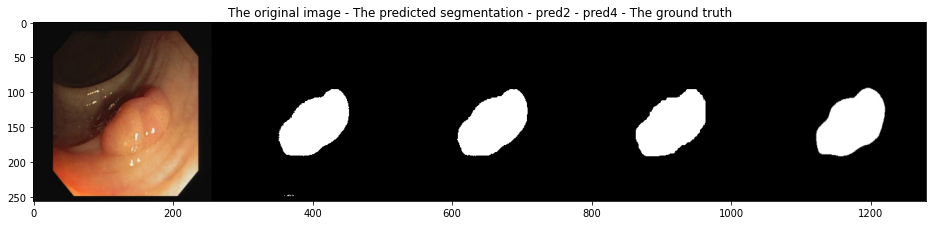

In [ ]:
#@title Segment an image
size = (256, 256)

def preprocessing(data, grey=False):
  X_tot = [get_image(img, 256, 256, grey) for img in data]
  x, edge = [],[]
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  # if grey:
  #   x = np.expand_dims(x, axis=3)
  return x, edge



def get_predict(model, img):
    processed_img, edge = preprocessing(img)
    edge = np.expand_dims(edge, axis=3)
    # processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict([processed_img, edge])
    print(len(out_put))
    result = []
    for out in out_put:
      out = out[..., -1]
      out = out[0]
      out = sklearn.preprocessing.binarize(out, threshold=0.5)
      out = out*255.
      out = out.astype(np.uint8)
      out = np.stack([out, out, out], axis=-1)
      result.append(out)
    return result

#@markdown Choose a number between 1 to 61
index =  12#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
result = get_predict(model, [x])
out_put2 = np.concatenate([cv2.resize(img2, size), result[0], result[2], result[3], cv2.resize(groundthruth, size)], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - pred2 - pred4 - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))

## CVC train - kvasir test

In [ ]:
#@title Load model
#@markdown Enter your path to the model
model_base_path = "/content/drive/MyDrive/msvision/data/cvc/model/"#@param {type:"string"}
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

model = load_pretrained_model(model_base_path+"model2.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#@title Load test set
#@markdown Enter your path to the test folder
test_path = "/content/drive/MyDrive/msvision/data/kvasir/new_data1/test/"#@param {type:"string"}
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

path is :  /content/drive/MyDrive/msvision/data/kvasir/new_data1/test/image/cju2i03ptvkiu0799xbbd4det_0.jpg
4


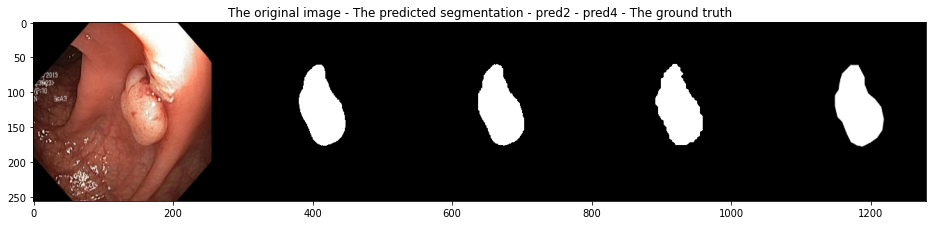

In [ ]:
#@title Segment an image
size = (256, 256)

def preprocessing(data, grey=False):
  X_tot = [get_image(img, 256, 256, grey) for img in data]
  x, edge = [],[]
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  # if grey:
  #   x = np.expand_dims(x, axis=3)
  return x, edge



def get_predict(model, img):
    processed_img, edge = preprocessing(img)
    edge = np.expand_dims(edge, axis=3)
    # processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict([processed_img, edge])
    print(len(out_put))
    result = []
    for out in out_put:
      out = out[..., -1]
      out = out[0]
      out = sklearn.preprocessing.binarize(out, threshold=0.5)
      out = out*255.
      out = out.astype(np.uint8)
      out = np.stack([out, out, out], axis=-1)
      result.append(out)
    return result

#@markdown Choose a number between 1 to 100
index =  17#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
result = get_predict(model, [x])
out_put2 = np.concatenate([cv2.resize(img2, size), result[0], result[2], result[3], cv2.resize(groundthruth, size)], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - pred2 - pred4 - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))

## kvasir train - kvasir test

In [ ]:
#@title Load model
#@markdown Enter your path to the model
model_base_path = "/content/drive/MyDrive/msvision/data/kvasir/model/"
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

model = load_pretrained_model(model_base_path+"model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#@title Load test set
#@markdown Enter your path to the test folder
test_path = "/content/drive/MyDrive/msvision/data/kvasir/new_data1/test/"#@param {type:"string"}
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

path is :  /content/drive/MyDrive/msvision/data/kvasir/new_data1/test/image/cju2hugv9vget0799hhk7ksvg_0.jpg
4


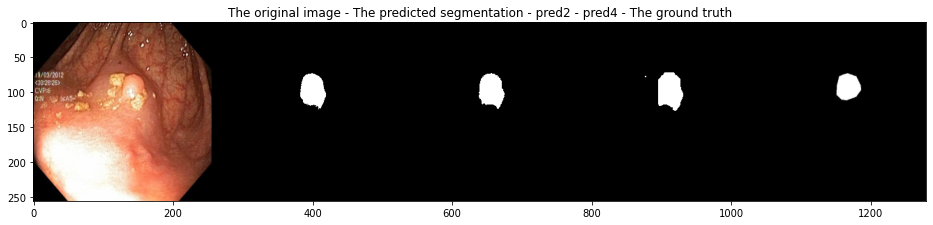

In [ ]:
#@title Segment an image
size = (256, 256)

def preprocessing(data, grey=False):
  X_tot = [get_image(img, 256, 256, grey) for img in data]
  x, edge = [],[]
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  # if grey:
  #   x = np.expand_dims(x, axis=3)
  return x, edge



def get_predict(model, img):
    processed_img, edge = preprocessing(img)
    edge = np.expand_dims(edge, axis=3)
    # processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict([processed_img, edge])
    print(len(out_put))
    result = []
    for out in out_put:
      out = out[..., -1]
      out = out[0]
      out = sklearn.preprocessing.binarize(out, threshold=0.5)
      out = out*255.
      out = out.astype(np.uint8)
      out = np.stack([out, out, out], axis=-1)
      result.append(out)
    return result

#@markdown Choose a number between 1 to 100
index =  16#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
result = get_predict(model, [x])
out_put2 = np.concatenate([cv2.resize(img2, size), result[0], result[2], result[3], cv2.resize(groundthruth, size)], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - pred2 - pred4 - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))

## kvasir train - cvc test

In [ ]:
#@title Load model
#@markdown Enter your path to the model
model_base_path = "/content/drive/MyDrive/msvision/data/kvasir/model/"
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

model = load_pretrained_model(model_base_path+"model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#@title Load test set
#@markdown Enter your path to the test folder
test_path = "/content/drive/MyDrive/msvision/data/cvc/new_data/test/"#@param {type:"string"}
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

path is :  /content/drive/MyDrive/msvision/data/cvc/new_data/test/image/275_0.jpg
4


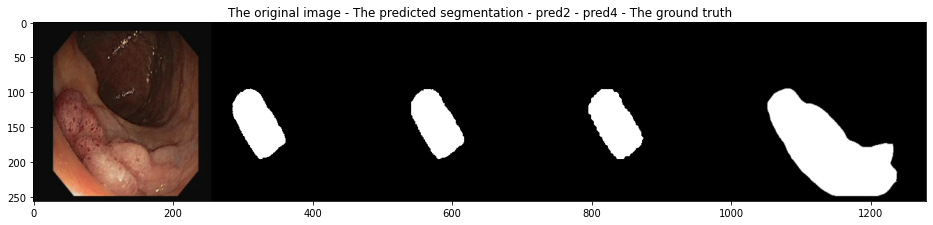

In [ ]:
#@title Segment an image
size = (256, 256)

def preprocessing(data, grey=False):
  X_tot = [get_image(img, 256, 256, grey) for img in data]
  x, edge = [],[]
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  # if grey:
  #   x = np.expand_dims(x, axis=3)
  return x, edge



def get_predict(model, img):
    processed_img, edge = preprocessing(img)
    edge = np.expand_dims(edge, axis=3)
    # processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict([processed_img, edge])
    print(len(out_put))
    result = []
    for out in out_put:
      out = out[..., -1]
      out = out[0]
      out = sklearn.preprocessing.binarize(out, threshold=0.5)
      out = out*255.
      out = out.astype(np.uint8)
      out = np.stack([out, out, out], axis=-1)
      result.append(out)
    return result

#@markdown Choose a number between 1 to 61
index =  19#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
result = get_predict(model, [x])
out_put2 = np.concatenate([cv2.resize(img2, size), result[0], result[2], result[3], cv2.resize(groundthruth, size)], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - pred2 - pred4 - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))

## Bowl test

In [ ]:
#@title Load model
#@markdown Enter your path to the model
model_base_path = "/content/drive/MyDrive/msvision/data/bowl/model/"#@param {type:"string"}
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

model = load_pretrained_model(model_base_path+"model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#@title Load test set
#@markdown Enter your path to the test folder
test_path = "/content/drive/MyDrive/msvision/data/bowl/new_data1/test/"#@param {type:"string"}
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

path is :  /content/drive/MyDrive/msvision/data/bowl/new_data1/test/image/1d4a5e729bb96b08370789cad0791f6e52ce0ffe1fcc97a04046420b43c851dd_0.jpg
4


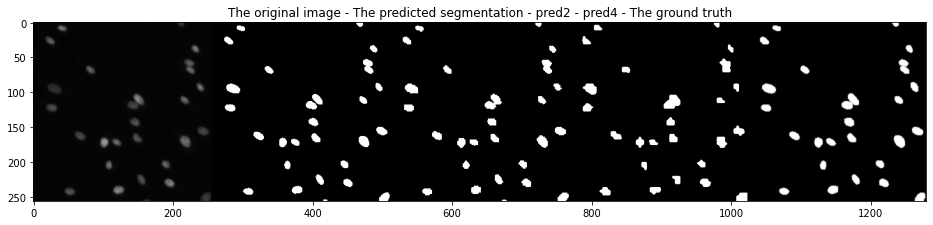

In [ ]:
#@title Segment an image
size = (256, 256)

def preprocessing(data, grey=False):
  X_tot = [get_image(img, 256, 256, grey) for img in data]
  x, edge = [],[]
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  # if grey:
  #   x = np.expand_dims(x, axis=3)
  return x, edge



def get_predict(model, img):
    processed_img, edge = preprocessing(img)
    edge = np.expand_dims(edge, axis=3)
    # processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict([processed_img, edge])
    print(len(out_put))
    result = []
    for out in out_put:
      out = out[..., -1]
      out = out[0]
      out = sklearn.preprocessing.binarize(out, threshold=0.5)
      out = out*255.
      out = out.astype(np.uint8)
      out = np.stack([out, out, out], axis=-1)
      result.append(out)
    return result

#@markdown Choose a number between 1 to 61
index =  14#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
result = get_predict(model, [x])
out_put2 = np.concatenate([cv2.resize(img2, size), result[0], result[2], result[3], cv2.resize(groundthruth, size)], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - pred2 - pred4 - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))

## lesion

In [ ]:
#@title Load model
#@markdown Enter your path to the model
model_base_path = "/content/drive/MyDrive/msvision/data/lesion/model/"#@param {type:"string"}
def load_pretrained_model(path):
  optimizer = get_optimizer()
  metrics = [
          dice_coef,
          iou,
          Recall(),
          Precision()]
  model = tf.keras.models.load_model(path,custom_objects={"seg_loss" : seg_loss, "x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss, 'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou,})
  model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss={"x": seg_loss, "edge_out": "binary_crossentropy", "pred4": seg_loss, "pred2": seg_loss},
        loss_weights={"x": 2.0, "edge_out": 1.0, "pred4": 1.0, "pred2": 1.0})
  
  return model

model = load_pretrained_model(model_base_path+"model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#@title Load test set
#@markdown Enter your path to the test folder
test_path = "/content/drive/MyDrive/msvision/data/lesion/new_data1/test/"#@param {type:"string"}
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

path is :  /content/drive/MyDrive/msvision/data/lesion/new_data1/test/image/ISIC_0000209_0.jpg
4


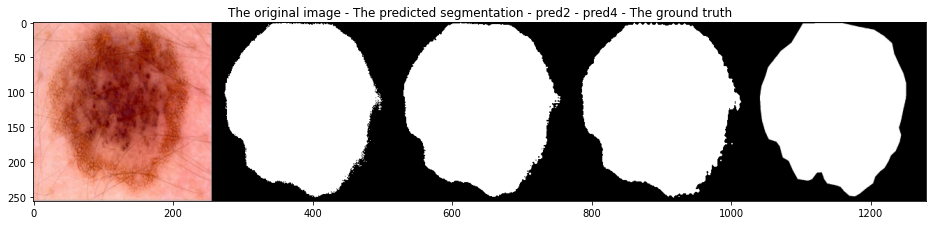

In [ ]:
#@title Segment an image
size = (256, 256)

def preprocessing(data, grey=False):
  X_tot = [get_image(img, 256, 256, grey) for img in data]
  x, edge = [],[]
  for i in range(0, len(X_tot)):
      x.append(X_tot[i][0])
      edge.append(X_tot[i][1])
  x = np.array(x).astype(np.float32)
  edge = np.array(edge).astype(np.float32)
  # if grey:
  #   x = np.expand_dims(x, axis=3)
  return x, edge



def get_predict(model, img):
    processed_img, edge = preprocessing(img)
    edge = np.expand_dims(edge, axis=3)
    # processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict([processed_img, edge])
    print(len(out_put))
    result = []
    for out in out_put:
      out = out[..., -1]
      out = out[0]
      out = sklearn.preprocessing.binarize(out, threshold=0.5)
      out = out*255.
      out = out.astype(np.uint8)
      out = np.stack([out, out, out], axis=-1)
      result.append(out)
    return result

#@markdown Choose a number between 1 to 259
index =  15#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
result = get_predict(model, [x])
out_put2 = np.concatenate([cv2.resize(img2, size), result[0], result[2], result[3], cv2.resize(groundthruth, size)], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - pred2 - pred4 - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))